# GRO620 - Problématique

Voici le fichier de départ de la problématique. Si tout a été installé correctement, vous devriez voir apparaître la première image (DSCF8010.jpeg).

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os
from enum import Enum

print("GRO620 - Problématique")
print("OpenCV version", cv2.__version__)

%matplotlib inline

GRO620 - Problématique
OpenCV version 4.6.0


In [2]:
images_fn = os.listdir("photos_prob/")
print("%i photo(s) à traiter"%(len(images_fn)))
if (len(images_fn) == 0):
    print("ERREUR! Vérifiez que vous avez bien un dossier photos_prob au même endroit que ce calepin.")
    
images_org = []

for f in images_fn:
    img = cv2.imread(os.path.join("photos_prob/", f))
    images_org.append(img)

9 photo(s) à traiter


## Identification du problème

Afin de faciliter le triage de quincaillerie provenant de meubles usagés, un montage a été conçu consistant d'un convoyeur acheminant les composantes en question et d'une caméra pour faire une preuve de concept. La caméra est localisée au-dessus du convoyeur de manière qu'elle puisse voir toute la largeur du convoyeur. Les vis sur le convoyeur passent donc par le champ de vision de la caméra qui a pour fonctions de les localiser et d'identifier leur type. Les images ont comme fond la surface du tapis du convoyeur, il faut donc être en mesure d'isoler les vis pour faciliter leur repérage. Il faut également filtrer les reliures (les imperfections) du tapis pour éviter les fausses détections. Finalement, Afin de s'assurer qu'il n'y ait pas d'erreurs de détection du type de vis ou de leur centre, les vis qui n'apparaissent pas dans leur entièreté dans l'image ne seront pas considérées.

### Correction des couleurs de l'image

On doit d'abord redresser les couleurs dans leur bon canal pour obtenir les couleurs originales des images.<br>
En effet, deux canaux de couleur ont été inversés, il faut donc les interchanger tel que d'écrit dans les commentaires du code ci-dessous pour les remettre dans le bon ordre RGB.

(<AxesSubplot:>, <matplotlib.image.AxesImage at 0x1e7e7ba6b60>)

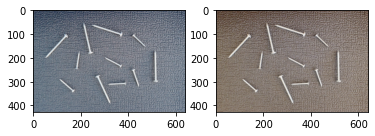

In [3]:
images_colored = []
image_amount: int = len(images_org)

for i in range(image_amount):
    images_colored.append(images_org[i].copy())
    images_colored[i][:, :, 2] = images_org[i][:, :, 0] # (RGB) Canal 0 images_org correspond au bleu donc doit aller dans le canal 2
    images_colored[i][:, :, 0] = images_org[i][:, :, 2] # (RGB) Canal 2 images_org correspond au rouge donc doit aller dans le canal 0

image_nb: int = 0
plt.subplot(1, 2, 1), plt.imshow(images_org[image_nb], cmap="gray")
plt.subplot(1, 2, 2), plt.imshow(images_colored[image_nb])

## Traitement d'image
Les images originales captées par la caméra présentent plusieurs imperfections telles que la texture du cuire sur le fond de l'image qui créer des reflets et des ombrages et les reliures dans le tapis du convoyeur qui créer des crevasses avec des contours bien définis. Ces imperfections rendent la détection des vis difficiles, car les algorithmes de détections de contours identifieraient non seulement les vis, mais aussi toutes les petites imperfections dans les images. Il faut donc éliminer ces imperfections pour avoir un arrière-plan uniforme et être en mesure de détecter uniquement le contour des vis. <br><br>
On filtre d'abord les images pour faire ressortir les vis de l’arrière-plan. Le filtrage de l'image s'effectue en plusieurs étapes expliquées ci-dessous avec le code associé.

### Première étape
Tout d'abord, il faut égaliser la couleur du fond pour retirer les reflets et les ombrages dans la texture. Une méthode est d'appliquer un filtre gaussien qui agit comme un filtre passe-bas atténuant ainsi les hautes fréquences associées aux imperfections dans l'image. Ceci a pour effet de rendre l'image flou et de retirer des détails superflus, donc le bruit. <br>

Ce filtre prend en paramètre le nombre de pixels (N) à considérer autour de chaque pixel de l'image et crée une matrice NxN. Chaque pixel de l'image est donc moyenné avec les autres pixels de sa matrice ce qui donne l'effet du flou. <br>

Le filtre gaussien a été implémenté à l'aide de la fonction GaussianBlur de la librairie OpenCV avec une taille de 5x5. Cette taille évite de perdre trop de détail dans les vis, mais retire une partie du bruit du fond. Il reste cependant trop d'imperfections après l'application du GaussianBlur, donc il faut appliquer d'autres filtres expliqués aux étapes suivantes pour obtenir une image contenant que les vis.

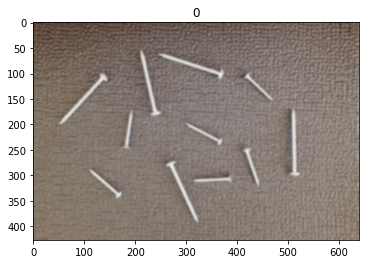

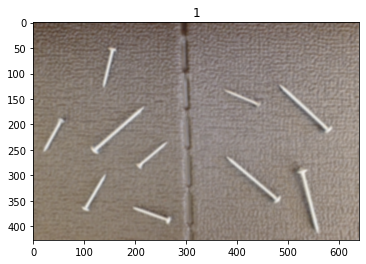

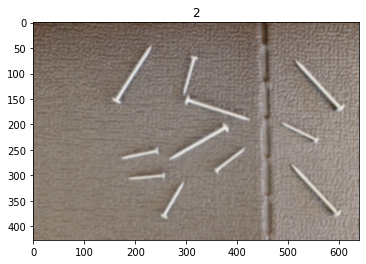

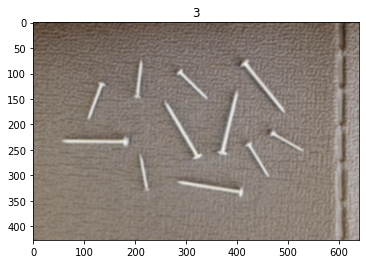

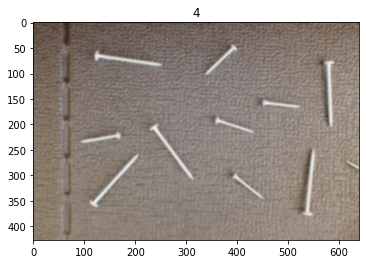

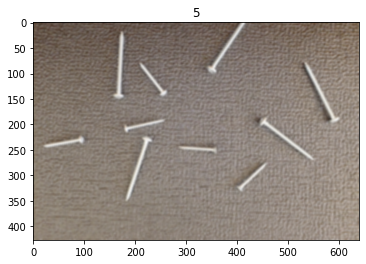

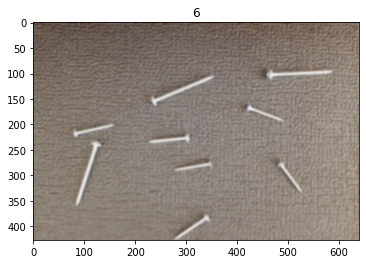

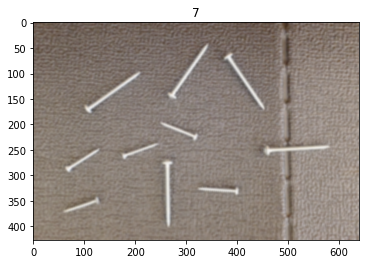

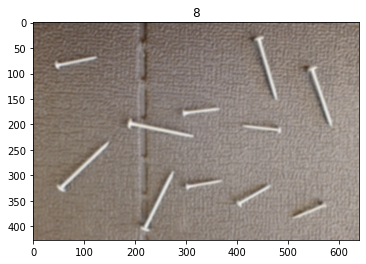

In [4]:
images_blured = []
for index in range(image_amount):
    images_blured.append(images_colored[index].copy())
    
    images_blured[index] = cv2.GaussianBlur(images_blured[index], (5,5), cv2.BORDER_DEFAULT)
    
    plt.figure()
    plt.imshow(images_blured[index], cmap="gray")
    plt.title(index)

### Deuxième étape
On applique un filtre non-linéaire de type bilatérale pour lisser le fond et retirer toute la texture du cuire. Ce type de filtre permet de réduire le bruit des images tout en préservant les contours puisqu'il consiste à moduler l'intensité d'un pixel à l'aide d'une moyenne pondérée des valeurs de pixels environnent. <br><br>
Les divers paramètres de la fonction bilateralFilter permettent de définir la taille du filtre, la distance de séparation entre les pixels et la valeur de l'écart type. <br><br>
Les valeurs de ces paramètres ont été déterminées de manière itérative en fonction du temps de compilation et de la qualité des images obtenues, soit l'accentuation des contours des vis et la réduction du bruit.
Le filtre est appliqué 3 fois itérativement, afin de s'assurer que le bruit soit réduit à un niveau acceptable.

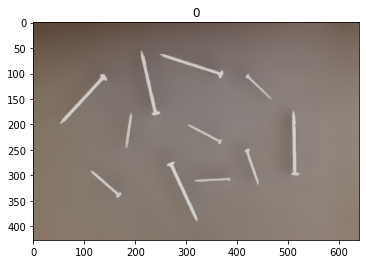

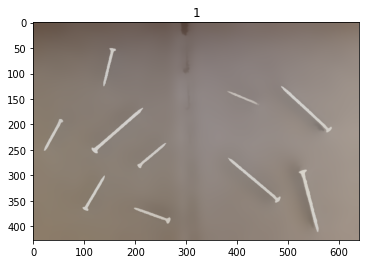

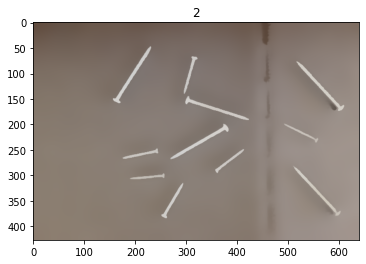

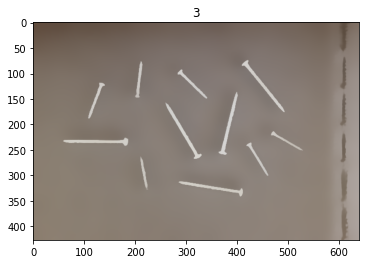

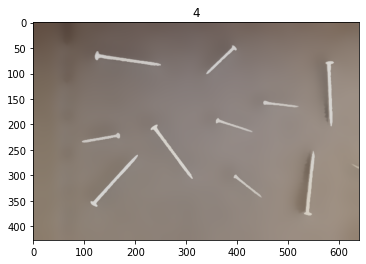

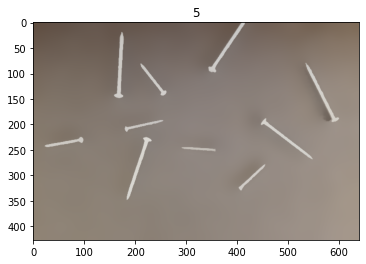

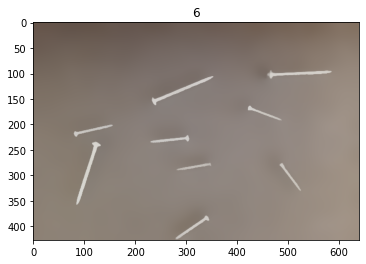

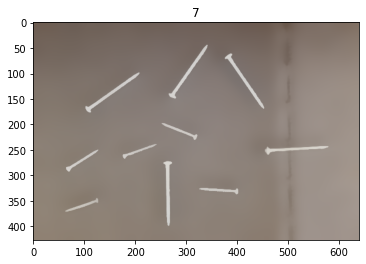

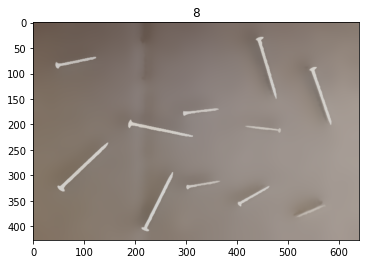

In [5]:
images_filtered = []
for index in range(image_amount):
    images_filtered.append(images_blured[index].copy())
    
    for iteration in range(3):
        images_filtered[index] = cv2.bilateralFilter(images_filtered[index], 30, 55, 50)
    plt.figure()
    plt.imshow(images_filtered[index], cmap="gray")
    plt.title(index)

### Troisième étape
Il reste encore les reliures du tapis dans les images. Celles-ci peuvent être retirées par un seuil sur le niveau d'intensité de gris dans l'image en la convertissant en teinte de gris, puisqu'il y a une distinction assez visible de teintes entre les vis et le fond.  <br><br>
Après avoir converti l'image en gris à l'aide de la fonction cvtColor(), il est possible d'en extraire son histogramme pour voir la répartition de de l'intensité de chaque pixel et ainsi déterminer le seuil d'intensité qui permet d'isoler les vis, ou plutôt d'éliminer les imperfections de fond restantes. <br><br>
L'histogramme de chaque image est ressorti avec la fonction calcHist à laquelle on spécifie le canal 0 pour ressortir les données d'une image grise. On peut ensuite spécifier la taille de l'histogramme, soit 256 ici, et la plage de valeur d'intensité des pixels, soit de 0 à 256 ici.

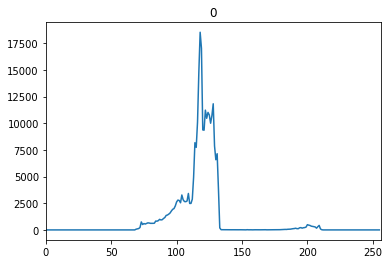

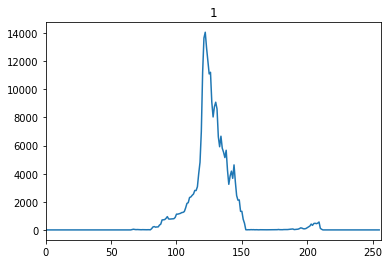

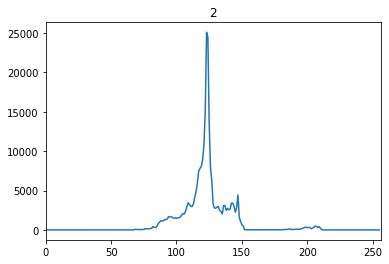

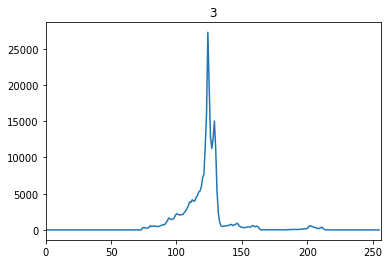

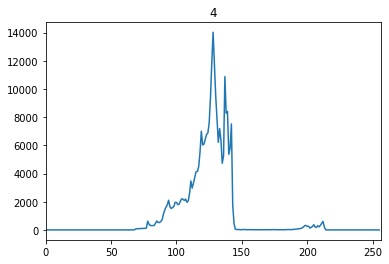

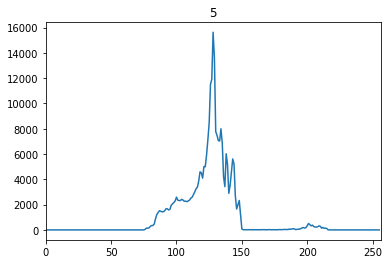

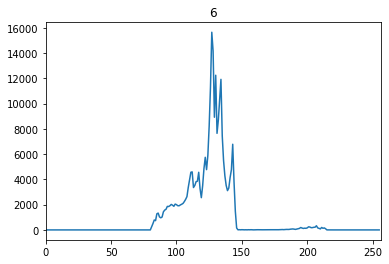

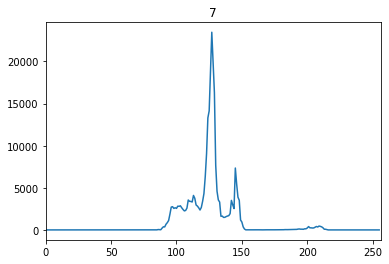

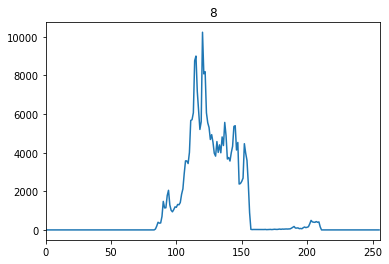

In [6]:
images_gray = []
for index in range(image_amount):
    images_gray.append(images_filtered[index].copy())
    
    images_gray[index] = cv2.cvtColor(images_gray[index], cv2.COLOR_BGR2GRAY)
    hist = cv2.calcHist([images_gray[index]], [0], None, [256], [0,256])

    plt.figure()
    plt.plot(hist)
    plt.xlim([0,256])
    plt.title(index)

### Quatrième étape
À partir du résultat de l'étape précédente, soit les histogrammes générés, il est possible de voir qu'une grande quantité de pixels possèdent une valeur d'intensité de gris dans la plage de 75 à 150 (environ) et une petite portion se retrouve au dessus de 200. Considérant que la teinte de gris du fond présente la majorité des pixels dans l'image, il est possible de déterminer que les pixels dans la plage de 75 à 150 sont les valeurs d'intensité à éliminer et qu'il faut seulement garder les pixels au dessus de 200 pour conserver les vis. Le seuil a donc été fixé à 170. <br><br>
Afin d'appliquer ce seuil sur les images, la fonction threshold a été utilisée avec le mode binaire afin d'éliminer de réduire à 0 l'intensité des pixels ne correspondant pas à la plage de valeur demandée, soit 170 à 255.

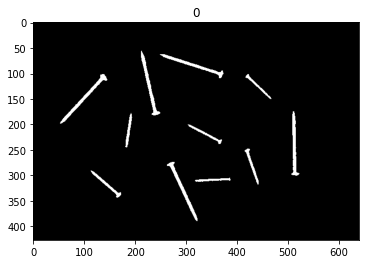

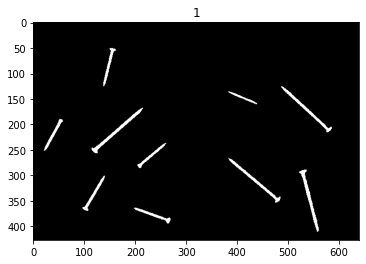

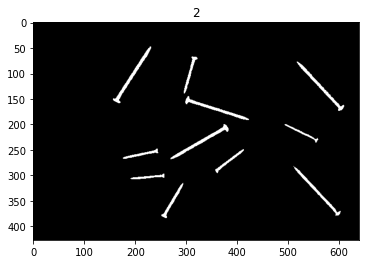

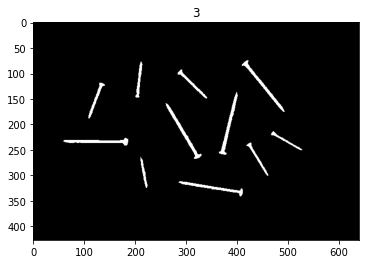

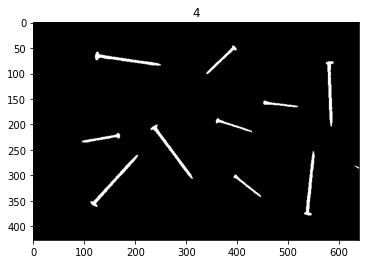

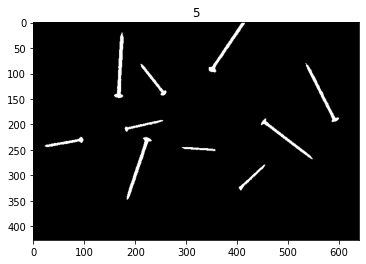

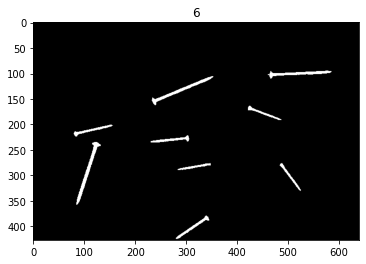

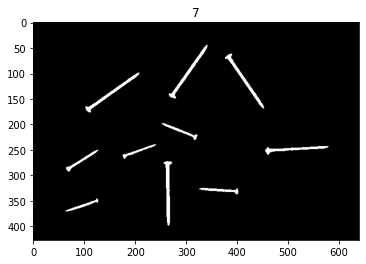

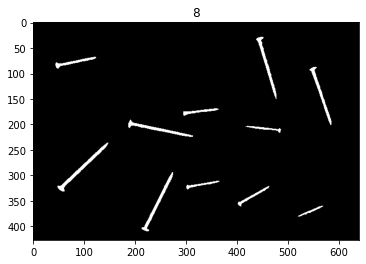

In [7]:
images_thresholded = []
for index in range(image_amount):
    images_thresholded.append(images_gray[index].copy())

    (thresh, images_thresholded[index]) = cv2.threshold(images_thresholded[index], 170, 255, cv2.THRESH_BINARY)
    
    plt.figure()
    plt.imshow(images_thresholded[index], cmap="gray")
    plt.title(index)

## Identification des vis
Une fois l'image traitée et les vis clairement isolées du fond, il est possible d'identifier chacune des vis à partir de leur contour. Il est ensuite possible d'extrapoler des formes simples à partir du contour des vis pour en extraire le centre, le type et l'orientation de celles-ci.

### Classes
Pour simplifier le traitement de chacune des vis, des classes ont été élaborées contenants les caractéristiques à extraire des vis. <br><br>

Le type de vis est décrit par une classe enum contenant les options longues ou courte. <br><br>

La classe _Line_ permet de calculer l'angle des vis à partir de deux points sur une droite alignée sur l'orientation d'une vis. <br><br>

La classe _Screw_ représente les données d'une vis spécifique, elle contient l'angle, le type de vis et les coordonnées x, y, z dans le repère du convoyeur pour chacune des vis. Le constructeur reçoit en paramètre le centre de la vis qui correspond aux coordonnées en pixels dans l'image, la longueur de la vis en pixel et la ligne de l'orientation (il sera expliqué à la prochaine étape comment ces données sont obtenues). L'angle se calcul donc avec la méthode get_angle de l'objet _Line_. Le type de vis est assigné en fonction de la longueur de la vis, donc courte pour une vis de moins de 100 pixels et longue pour une vis de plus de 100. <br><br>

Pour obtenir les coordonnées dans le repère du convoyeur, les coordonnées en pixel du centre des vis doivent être projetées d'un espace 2D dans la caméra à un espace en 3D sur le convoyeur. C'est l'équation (2.65) du livre qui est mise en œuvre. <br><br>

$x_s \sim \tilde{P} \bar{p_w}$ <br><br>

Il faut d'abord trouver la matrice de projection $\tilde{P}$ à partir de la matrice de configuration intrinsèque augmentée $\tilde{K}$ et de la matrice de transformation Tc. $\tilde{P}$ est obtenu en prenant l'inverse de la multiplication de $\tilde{K}$ avec T0C (l'inverse de Tc). Cette opération est faite dans la méthode _define_projection_matrix. <br><br>

Il faut ensuite normaliser les coordonnées reçues en pixel du centre de la vis avant de faire la multiplication par $\tilde{P}$. Pour ce faire, $x_s$ est mise sous ce format : $x_s = (x, y, 1, d)$ où $d = 1/z$ et $z = 0,282$. Les coordonnées sont normalisées en multipliant $x_s$ par $z$. Les coordonnées dans le repère du convoyeur sont ensuite obtenues en faisant la multiplication de $\tilde{P}$ avec $x_s$.

C'est la méthode _define_screw_coordinates qui s'en charge.

In [8]:
class Screw_type(Enum):
    longue = 1
    courte = 2

class Line:
    def __init__(self, point_1, point_2):
        self.point_1: tuple = point_1
        self.point_2: tuple = point_2

    def get_angle(self):
        return np.arctan2(self.point_2[1] - self.point_1[1], self.point_2[0] - self.point_1[0])

class Screw():
    def __init__(self, center, length, line: Line):
        self.p_tilde = self._define_projection_matrix()
        self.angle: float = line.get_angle()
        self.type: Screw_type = self._define_screw_type(length)
        (self.x, self.y, self.z) = self._define_screw_coordinates(center)
        

    def _define_projection_matrix(self):
        sensor_height_px = 427
        sensor_width_px = 640
        sensor_width_mm = 23.4
        focal_dist_mm = 23
        focal_dist = focal_dist_mm*sensor_width_px/sensor_width_mm

        Tc = np.array([[1,   0,  0,   0.5],
                      [0,   -1, 0,   0.2],
                      [0,   0,  -1,  0.282],
                      [0,   0,  0,   1]])

        Tc_inv = np.linalg.inv(Tc)

        k_tilde = np.array([[focal_dist,   0,          sensor_width_px/2,   0],
                            [0,            focal_dist, sensor_height_px/2,  0],
                            [0,            0,          1,                   0],
                            [0,            0,          0,                   1]])
        
        return k_tilde @ Tc_inv

    def _define_screw_type(self, length) -> Screw_type:
        if (length > 100):
            return Screw_type.longue
        else:
            return Screw_type.courte

    def _define_screw_coordinates(self, center_px) -> tuple:
        z = 0.282 

        coordinate_camera_frame = np.array([[center_px[0]], [center_px[1]], [1], [1/z]]) * z
        coordinate_conveyor_frame = np.linalg.inv(self.p_tilde) @ coordinate_camera_frame
        return tuple([float(coordinate_conveyor_frame[0]), float(coordinate_conveyor_frame[1]), float(coordinate_conveyor_frame[2])])

    


### Identification des paramètres des vis

La première étape pour identifier les données pertinentes des vis est de ressortir les contours des vis à la suite de l'application du "threshold" effectuée plus tôt. Cette opération est effectuée par la fonction findContours() à laquelle on spécifie comme mode, la détection des contours externes puisqu'une détection permettant de trouver un contour interne dans une vis ne nous intéresse pas. On spécifie ensuite la méthode pour n'avoir aucune approximation, ceci permet de considérer tous les points d'un contour et ainsi obtenir le résultat le plus précis possible. <br><br>

Une fois les contours des vis extraits, il faut identifier les vis à retirer lorsqu'elles sortent du cadre de l'image. Pour ce faire, un rectangle en angle d'aire minimale est extrapolé à partir des contours trouvés. Un objet de type _Box_ extrait les coordonnées des pixels associées aux 4 coins de ce rectangle. Il faut ensuite retirer toutes les vis dont l'un de ces 4 coins du rectangle est trop proche du rebord de l'image ou en sort. Ceci est fait avec une zone rectangulaire de 638x425 centré dans l'image. Tous les coins des rectangles situés à l'extérieur de cette zone permettent d'identifier les vis invalides. Comme l'image a une résolution de 640x427, il y a une marge de 2 pixels autour de l'image où les coins des rectangles sont considéré trop proche. <br><br>

Une fois les contours obtenus et validés, il est possible d'en extrapoler des formes géométriques simples afin d'obtenir les données désirées. La première forme est la génération d'un cercle qui se base sur les points aux limites des contours. Ceci nous permet d'obtenir deux informations, soit le centre du cercle qui correspond au centre de la vis ainsi que le rayon du cercle, ce qui correspond alors à la longueur totale de la vis divisé par 2. Cette forme peut être obtenue à l'aide de la fonction minEnclosingCircle() à laquelle on spécifie le contour en question. <br><br>

La seconde forme générée est une simple ligne qui permet par la suite de déterminer l'orientation de la vis. Cette forme peut être obtenu à l'aide de la fonction fitLine() qui permet par la suite d'obtenir le positionnement de deux points sur le long de la ligne qui serviront au calcul de l'orientation à l'aide de la classe _Line_ présentée plus tôt.

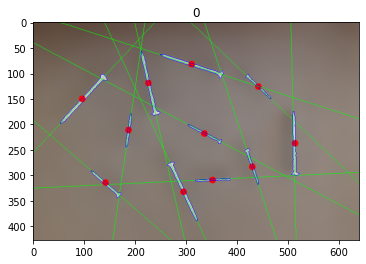

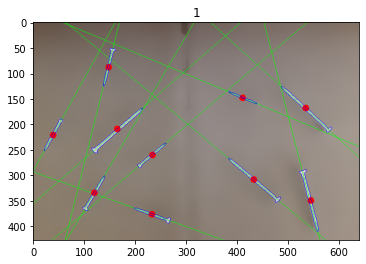

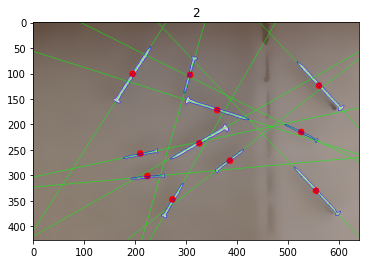

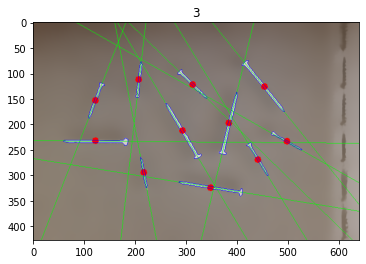

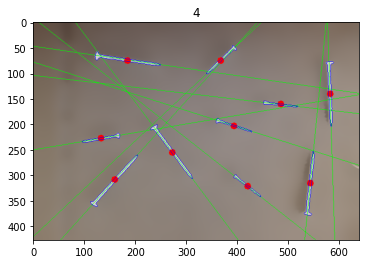

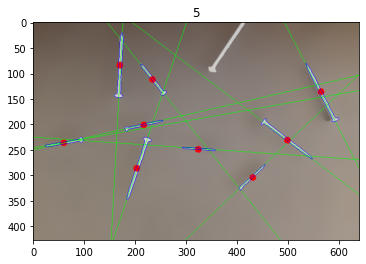

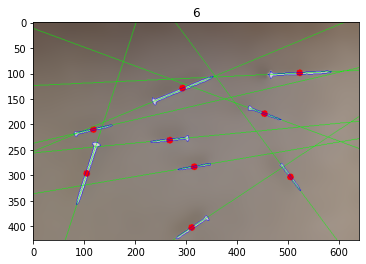

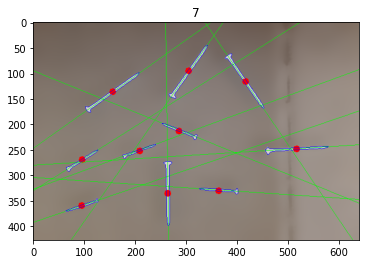

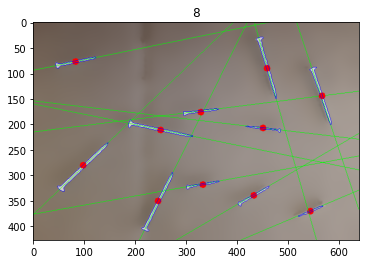

In [9]:
screws = []
images_contour = []

for index in range(image_amount):
    screws.append([])
    images_contour.append(images_filtered[index].copy())

    contours, hierarchy = cv2.findContours(images_thresholded[index], cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)

    detected_screw = []

    for contour in contours:
        rect = cv2.minAreaRect(contour)
        box = cv2.boxPoints(rect)
        box = np.int0(box)

        if not (box[0][0] < 2 or box[0][0] > 638 or box[0][1] < 2 or box[0][1] > 425 or
                box[1][0] < 2 or box[1][0] > 638 or box[1][1] < 2 or box[1][1] > 425 or
                box[2][0] < 2 or box[2][0] > 638 or box[2][1] < 2 or box[2][1] > 425 or
                box[3][0] < 2 or box[3][0] > 638 or box[3][1] < 2 or box[3][1] > 425):
            detected_screw.append(contour)

    for contour in detected_screw:
        # Orientation (ligne)
        rows,cols = images_contour[index].shape[:2]
        [vx,vy,x,y] = cv2.fitLine(contour, cv2.DIST_L2,0,0.01,0.01)
        lefty = int((-x*vy/vx) + y)
        righty = int(((cols-x)*vy/vx)+y)
        line = Line((cols-1,righty),(0,lefty))
        cv2.line(images_contour[index], line.point_1, line.point_2,(0,255,0),1)

        # Centre et longueur
        (x,y),radius = cv2.minEnclosingCircle(contour)
        center = (int(x),int(y))
        radius_printed: int = 3
        cv2.circle(images_contour[index],center,radius_printed,(255,0,0),5)

        # Contour de chaque vis
        cv2.drawContours(images_contour[index], detected_screw, -1, (0, 0, 255), 1)

        # Ajoute la vis à la liste pour l'image en cours
        screws[index].append(Screw(center, radius*2, line))

    plt.figure()
    plt.imshow(images_contour[index], cmap="gray")
    plt.title(index)

In [10]:
for index in range(image_amount):
    print("Image " + str(index+1))
    print("Id      Type         X(m)       Y(m)        Z(m)      Angle(rad)")
    screw_id = 0
    for screw in screws[index]:
        print("{:d}       {:s}       {:.2f}       {:.2f}       {:.2f}      {:.2f}".format(screw_id, screw.type.name, screw.x, screw.y, screw.z, screw.angle))
        screw_id += 1

Image 1
Id      Type         X(m)       Y(m)        Z(m)      Angle(rad)
0       courte       0.51       0.16       0.00      3.09
1       courte       0.42       0.15       0.00      -2.43
2       longue       0.49       0.15       0.00      -2.01
3       courte       0.55       0.17       0.00      -1.89
4       courte       0.51       0.20       0.00      -2.66
5       courte       0.44       0.20       0.00      1.72
6       longue       0.59       0.19       0.00      -1.59
7       courte       0.55       0.24       0.00      -2.38
8       longue       0.40       0.23       0.00      2.32
9       longue       0.50       0.26       0.00      -2.83
10       longue       0.46       0.24       0.00      -1.80
Image 2
Id      Type         X(m)       Y(m)        Z(m)      Angle(rad)
0       courte       0.46       0.13       0.00      -2.80
1       courte       0.41       0.15       0.00      2.10
2       longue       0.60       0.14       0.00      -1.82
3       longue       0.55      

## Analyse du résultat
Le processus de traitement d'image pour détecter les vis est très efficace puisqu'il permet d'isoler parfaitement les vis en éliminant complètement les détails non nécessaires, soit le le relief de cuire du fond et les reliures du tapis. Les méthodes de localisation et d'orientation des vis sont précises puisqu'elles générent des formes simples directement à partir des contours de vis ressortis dans les étapes précédentes. Ces formes ont été sélectionnées logiquement en fonction des informations qui doivent être ressorties par celles-ci, soit un cercle qui se base sur les extrémités du contour pour le centre de la vis et une ligne qui épouse parfaitement la longueur du contour pour l'orientation. De plus, pour s'assurer de la validité des données ressorties, une validation est présente pour que les vis considérées soient entièrement présentes dans l'image, il n'est donc pas possible de ressorti les données d'une moitié de vis, peu importe son type. <br><br>

Cependant, considérant que la caméra doit être en mesures d'analyser plusieurs images dans un cours lapse de temps, le temps d'exécution de l'ensemble du traitement peut être considéré comme étant assez long. De plus, il faut s'assurer que l'environnement d'acquisition de la caméra soit contrôlé pour être constant puisque que de simples modifications comme l'éclairage ambiant pourrait fausser nos résultats dû à l'utilisation du threshhold en fonction de l'intensité des valeurs de pixels par exemple. Le traitement d'image ne permet pas la présence de composantes autres que les vis sur le convoyeur puisque celles-ci pourraient causer des fausses détections. Finalement, les données ressorties de chaque vis permettent mal à une personne de pouvoir les identifier facilement, à l'oeil, en comparant les résultats à une image comportant plusieurs détections puisqu'un changement de repère et d'unité (pixel vers mètres) a été effectuée. <br><br>

Cependant, malgré ces défauts, les performances du système répondent aux requis puisque l'ordinateur embarqué du projet est suffisamement performant pour réduire les risques liés au temps d'exécution du traitement d'image. De plus, il est facile de contrôler l'environnement d'acquisition de la caméra puisque le montage est effectué à l'intérieur de l'usine, dans une zone dédiée à cette implémentation, il ne devrait donc pas y avoir de changements de ce côté. 


